<a href="https://colab.research.google.com/github/restrepo/COVID-19/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 data for Colombia

Use of [public Covid-19 in GitHub](https://github.com/CSSEGISandData/COVID-19) data from: 
[Center for Systems Science and Engineering (CSSE)](https://systems.jhu.edu/):

* Hongru Du, Lauren Gardner, and Ensheng Dong, An interactive web-based dashboard to track COVID-19 in real time, http://www.thelancet.com/infection Published:February 19, 2020, DOI:https://doi.org/10.1016/S1473-3099(20)30120-1

For examples of use of the data see Jupyter Notebook `covid19_analysis.ipynb`: [[local](./covid19_analysis.ipynb)] [[GitHub](https://github.com/restrepo/Covid-19/blob/master/covid_analysis.ipynb)] [[Colab](https://colab.research.google.com/github/restrepo/Covid-19/blob/master/covid_analysis.ipynb)]

[Official Colombia data](https://infogram.com/covid-2019-ins-colombia-1hnq41zg9ord63z)

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['DataSource']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
import pandas as pd
import re
#See https://strftime.org/
import datetime
import numpy as np
from scipy import optimize as opt

In [0]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))
    
def date_range(date_start='2/23/20',date_end='3/03/20',date_step=1):
    dr=[]
    start = datetime.datetime.strptime(date_start, "%m/%d/%y")
    end = datetime.datetime.strptime(date_end, "%m/%d/%y")
    step = datetime.timedelta(days=date_step)
    while start <= end:
        #avoid leading zeroes: https://stackoverflow.com/a/2073189/2268280
        dr.append(start.strftime("%-m/%-d/%y"))
        start += step
    return dr

def index_field(df,column,filter=None):
    '''
    WARNING: Nonumerical columns are dropped
    
    Parameters:
    ----------
    filter: list, default None
        Select only the columns in this list
    '''
    dff=df.copy()
    if filter:
        dff=df[[column]+list(filter)]
    return dff.groupby(column).sum()

def get_infected(country,date_start=None,date_end=None,DataFrame=None,
      DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/',
      DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
      ):
    '''
    Obtenga la lista de infectados de un país
     country: País
     date_start: Fecha inicial en el formato MM/DD/YY, e.g. '3/10/20' o None
     date_end  : Fecha final en el formato MM/DD/YY, e.g. '3/10/20' o None
     si alguna de las fechas esta en None se toma de los extremos del rango
     de fechas disponible
    '''
    if DataFrame is None:
        df=pd.read_csv('{}{}'.format(data_source,data_file))
        df=df.reset_index(drop=True)
    else:
        df=DataFrame.copy()

    d=[ c for c in df.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
    if not date_start:
        date_start=d[0]
    if not date_end:
        date_end=d[-1]
    dr=date_range(date_start=date_start,date_end=date_end)
    #country in df.index
    cvrg=df[dr]
    y=cvrg.loc[country].tolist()              
    return y

def dataframe_doubling(x,y,start_date,final_date):
    '''
    x: list of days
    y: list of infections
    '''
    sp=pd.DataFrame()
    if len(x)<3:
        print('WARNING: Not enough data: at least 3 days')
        return sp
    spd={'start_date':start_date,'final_date':final_date}
    for d in x[2:]:
        exp_fit = opt.curve_fit(exponential_model,x[:d],y[:d],p0=[1,0.4,3])
        spd['g']=exp_fit[0][1]
        N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
        if exponential_model(t0,N0,g,t0)==N0:
            Td=np.log(2)/g
            spd['N0']=exp_fit[0][0]
            spd['t0']=exp_fit[0][2]
            spd['Td']=Td
            spd['day']=d
            spd['infections']=y[d-1]
        sp=sp.append(spd,ignore_index=True)

    sp['day']=sp['day'].astype(int)
    sp['infections']=sp['infections'].astype(int)
    return sp

## Load data

In [0]:
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
cva=pd.read_csv('{}{}'.format(DataSource,DataFile))
cva=cva.reset_index(drop=True)
#Special cases
c='Hong Kong'
try:
    cva.loc[cva[cva['Province/State']==c].index[0],'Country/Region']=c
except IndexError:
    pass  

In [0]:
d=[ c for c in cva.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
cv=index_field(cva,"Country/Region",filter=d)

## Fix wrong data


In [0]:
FIX_DATA=False
if FIX_DATA:
    ic=cva[cva['Country/Region']=='Colombia'].index[0]
    cva.loc[ic,'3/23/20']=271

TODO: Use new method groupby

In [6]:
cva.groupby("Country/Region").sum().drop(['Lat','Long'],axis='columns').loc['Colombia'].values

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   1,   1,   1,   3,   9,   9,  13,
        22,  34,  54,  65,  93, 102, 128, 196, 231, 271, 378])

In [7]:
cva.groupby("Country/Region").sum().drop(['Lat','Long'],axis='columns').loc['Spain']

1/22/20        0
1/23/20        0
1/24/20        0
1/25/20        0
1/26/20        0
           ...  
3/20/20    20410
3/21/20    25374
3/22/20    28768
3/23/20    35136
3/24/20    39885
Name: Spain, Length: 63, dtype: int64

## Normalize data
Be sure to have only a row for country

In [8]:
cv=merge_country(cva)
cv.shape

(171, 67)

last update

In [13]:
dmax=d[-1]
dmax

'3/24/20'

## Fit to logistic or exponential model
See: 
* https://twitter.com/burkert_andreas/status/1239692655833071616
    * https://raw.githubusercontent.com/restrepo/Covid-19/master/covid-19.jpeg

* Method for Python explained in 
[Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d):

> While the logistic model describes an infection growth that is going to stop in the future, the exponential model describes an unstoppable infection growth. For example, if a patient infects 2 patients per day, after 1 day we’ll have 2 infections, 4 after 2 days, 8 after 3 and so on. The most generic exponential function is:

$$f(x,a,b,c)=a\operatorname{e}^{b(x-c)}\,.$$

Which can be [interpreted as](https://en.wikipedia.org/wiki/Doubling_time)
$$N(t)=N(t_0)\operatorname{e}^{g(t-t_0)}$$

or

$g = \dfrac{\ln\left(N(t)/N(t_0)\right)}{t-t_0}$

* $N(t)$ = the number of infections at time $t$
* $N(t_0)$ = the number of infections at time $t_0$
* $g$ = growth rate
* $t$ = time (usually in days)

Doubling time $T_d$:

$T_d = \dfrac{\ln(2)}{g}$

$T_d = (t-t_0)\dfrac{\ln(2)}{\ln\left(N(t)/N(t_0)\right)}$

For doubling times analysis for other countries see [Forbes](https://www.forbes.com/sites/startswithabang/2020/03/17/why-exponential-growth-is-so-scary-for-the-covid-19-coronavirus/#66dd44434e9b) - [Result](https://raw.githubusercontent.com/restrepo/Covid-19/master/img/doubling.jpg)



# Colombia

### Select data for Colombia

In [0]:
NOT_OFFICIAL_UPDATE=False
c='Colombia'
max_forecast=1000
prediction=20
extra_days=16
start_day='3/9/20'
#dr=date_range(date_start=start_day,date_end=dmax)
#cvrg=cv[cv['Country/Region']==c].reset_index(drop=True)
#y=cvrg[dr].values.tolist()[0]
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
if NOT_OFFICIAL_UPDATE:
    today=input('Last infections: ')
    y.append(int(today))
x=range(1,len(y)+1)

### Logistic model for Colombia

In [39]:
logistic_fit = opt.curve_fit(logistic_model,x,y,p0=[2,10,100])
'logistic end: {} ± {} infections'.format(int(logistic_fit[0][2]),
                               int(np.sqrt(logistic_fit[1][2,2])))

'logistic end: 1704 ± 1219 infections'

### Exponential model for Colombia

Prepare data

In [40]:
exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,1])
try:
    Δb=np.sqrt(exp_fit[1][1,1])
except:
    Δb=0
'exponential `b`-fitted parameter: {}  ± {}'.format(exp_fit[0][1].round(3),Δb.round(3))

'exponential `b`-fitted parameter: 0.254  ± 0.016'

Prediction next day

In [41]:
exp_fit_co=exp_fit[0].copy()
exponential_model_co=lambda x: exponential_model(x, exp_fit_co[0],exp_fit_co[1],exp_fit_co[2]  )
infc=exponential_model_co(x[-1]+1  )
pinfc=exponential_model(x[-1]+1, exp_fit_co[0],exp_fit_co[1]+Δb,exp_fit_co[2]  )-infc
minfc=infc-exponential_model(x[-1]+1, exp_fit_co[0],exp_fit_co[1]-Δb,exp_fit_co[2]  )
next_day=r'next day:  $%g^{+%g}_{-%g}$' %(
                        int( infc ),int( pinfc ),int( minfc )  )
print('day {}:  {} infections'.format(x[-1]+1,next_day) )

day 17:  next day:  $485^{+170}_{-125}$ infections


Iterpretation in terms of
$$N(t)=N(t_0)\operatorname{e}^{g(t-t_0)}$$

In [42]:
N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
if exponential_model(t0,N0,g,t0)==N0:
    Td=np.log(2)/g
else:
    print('WARNING: N(t) interpretation not working')
    Td=None
if Td:
    dt=re.sub('\.0\s',' ', '(doubling time = {} days)'.format(Td.round(1)
        ))
    texmodel='N(t)=N(t_0)e^{t-t_0}='
    print('T_d →  {}'.format(dt))
else:
    texmodel=''
    dt=''

T_d →  (doubling time = 2.7 days)


Visualization

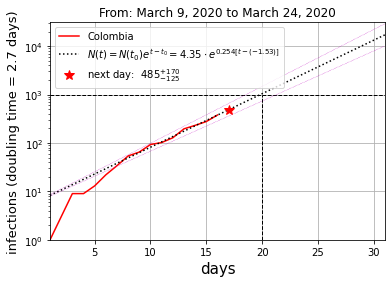

In [43]:
LOGISTIC=False
ERRORS=True
ylinlog='log'
xx=range(x[0],x[-1]+extra_days)
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%s%g\cdot e^{%g[t-(%g)]}$' %(texmodel,
                                             exp_fit[0][0].round(2),
                                             exp_fit[0][1].round(3),
                                             exp_fit[0][2].round(2)) )
if ERRORS:
    plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1]+Δb,exp_fit[0][2]),
         'm:',lw=0.5)
    plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1]-Δb,exp_fit[0][2]),
         'm:',lw=0.5)
if LOGISTIC:
    plt.plot(xx,
         logistic_model(xx,logistic_fit[0][0],logistic_fit[0][1],logistic_fit[0][2]),
         'c:',lw=1
          )

plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {} to {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y"),
    datetime.datetime.strptime(dmax,"%m/%d/%y").strftime("%B %-d, %Y") ) )
plt.plot(x[-1]+1,infc,'r*',markersize=10,
         label=next_day
         )

plt.legend(loc='upper left')
plt.xscale('linear')
plt.yscale(ylinlog)
plt.xlabel('days',size=15)
plt.ylabel('infections '+dt,size=13 )
if ylinlog=='linear':
    xmax=x[-1]+2
    ymax=y[-1]+infc+Δb
else:
    xmax=xx[-1]
    ymax=max_forecast+30000
plt.xlim(xx[0],xmax)
plt.ylim(ymin,ymax)
plt.grid()
plt.savefig('Colombia.png')


## Doubling time

In [44]:
sp=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


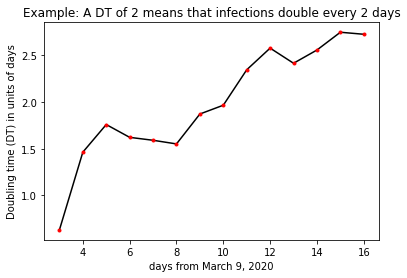

In [45]:
plt.plot(sp['day'],sp['Td'],'k-')
plt.plot(sp['day'],sp['Td'],'r.')
plt.title('Example: A DT of 2 means that infections double every 2 days')
plt.xlabel('days from {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y")
  ))
plt.ylabel('Doubling time (DT) in units of days')
plt.savefig('doublingtime.png')

### Other country

(27, 20000)

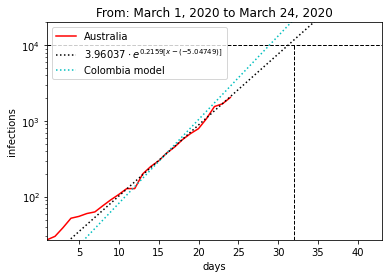

In [46]:
c='Australia'
max_forecast=10000
prediction=32#21
start_day='3/1/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,3])

xx=range(x[0],x[-1]+20)
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%g\cdot e^{%g[x-(%g)]}$' %(exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) )

plt.plot(xx,exponential_model_co(xx),'c:',label='Colombia model')

plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {} to {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y"),
    datetime.datetime.strptime(dmax,"%m/%d/%y").strftime("%B %-d, %Y") ) ) 
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('days')
plt.ylabel('infections')
plt.xlim(xx[0],xx[-1])
plt.ylim(ymin,max_forecast+10000)

In [47]:
N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
if exponential_model(t0,N0,g,t0)==N0:
    Td=np.log(2)/g
else:
    print('WARNING: N(t) interpretation not working')
    Td=None
if Td:
    dt='(doubling time = {} days)'.format(Td.round(2))
    print('T_d →  {}'.format(dt))

T_d →  (doubling time = 3.21 days)


In [48]:
spa=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [49]:
c='Spain'
start_day='3/1/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
sps=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [50]:
c='Italy'
start_day='3/1/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
spi=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


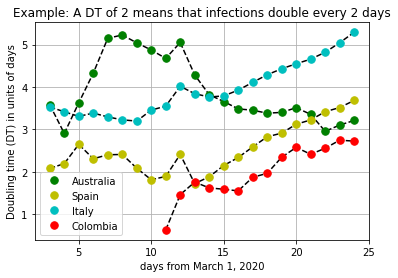

In [51]:
plt.plot(spa['day'],spa['Td'],'k--')
plt.plot(spa['day'],spa['Td'],'g.',markersize=15,label='Australia')
plt.plot(sps['day'],sps['Td'],'k--')
plt.plot(sps['day'],sps['Td'],'y.',markersize=15,label='Spain')
plt.plot(spi['day'],spi['Td'],'k--')
plt.plot(spi['day'],spi['Td'],'c.',markersize=15,label='Italy')
plt.plot(sp['day']+8,sp['Td'],'k--')
plt.plot(sp['day']+8,sp['Td'],'r.',markersize=15,label='Colombia')

plt.title('Example: A DT of 2 means that infections double every 2 days')
plt.xlabel('days from {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y")
  ))
plt.ylabel('Doubling time (DT) in units of days')
plt.savefig('doublingtime.png')
plt.legend()
plt.grid()

In [52]:
#Day 1: infections > 10
mininf=10
c='Italy'
start_day='2/19/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
spi=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)
c='Spain'
start_day='2/24/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
sps=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)
c='Colombia'
start_day='3/11/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=range(1,len(y)+1)
sp=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)
c='Korea, South'
start_day='2/18/20'
y=get_infected(c,date_start=start_day,date_end='3/11/20',DataFrame=cv)
x=range(1,len(y)+1)
spk=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


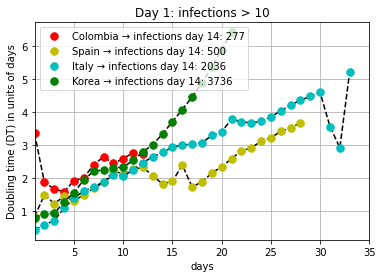

In [55]:
plt.plot(sp['day']-2,sp['Td'],'k--')
plt.plot(sp['day']-2,sp['Td'],'r.',markersize=15,
         label='Colombia → infections day {}: {}'.format(
                 fd+3,sp.loc[fd-1,'infections']))
plt.plot(sps['day']-2,sps['Td'],'k--')
plt.plot(sps['day']-2,sps['Td'],'y.',markersize=15,
         label='Spain → infections day {}: {}'.format(
                 fd+3,sps.loc[fd-1,'infections']))
plt.plot(spi['day']-2,spi['Td'],'k--')
plt.plot(spi['day']-2,spi['Td'],'c.',markersize=15,
         label='Italy → infections day {}: {}'.format(
                 fd+3,spi.loc[fd-1,'infections']))
plt.plot(spk['day']-2,spk['Td'],'k--')
plt.plot(spk['day']-2,spk['Td'],'g.',markersize=15,
         label='Korea → infections day {}: {}'.format(
                 fd+3,spk.loc[fd-1,'infections']))

plt.legend()
plt.title('Day 1: infections > 10')
plt.xlabel('days')
plt.ylabel('Doubling time (DT) in units of days')
plt.legend()
plt.grid()
plt.xlim(1,spi['day'].max())
plt.savefig('contention.png')

### Last update

In [60]:
cv.loc['Colombia'][-1:]

3/24/20    378
Name: Colombia, dtype: int64

## Last official data from Colombia

In [65]:
import requests
import pandas as pd

r=requests.get('https://infogram.com/covid-2019-ins-colombia-1hnq41zg9ord63z')

head='"data":[[["ID de caso",'
tail=']]]'
js='{}{}{}'.format( head.split(':')[-1],
                 r.text.split(head)[-1].split(tail)[0],
                 tail
             )

df=pd.read_json(js)

coco=pd.DataFrame([l for l in df[range(1,df.columns[-1]+1)].values[0]],columns=df[0][0] )
#coco['Fecha']=pd.to_datetime(coco['Fecha de diagnóstico'],format="%d/%m/%Y")

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [72]:
for i in df.columns:
    df[i]
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [74]:
[ l for l in df[i] if l ]

[['', '', '', '', '', '', '0', '', '']]

In [66]:
coco[coco['Fecha de diagnóstico']==coco['Fecha de diagnóstico'].tolist()[-1]]

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento,Atención,Edad,Sexo,Tipo*,País de procedencia
470,,,,,,,,,
471,,,,,,,,,
472,,,,,,,,,
473,,,,,,,,,
474,,,,,,,,,
...,...,...,...,...,...,...,...,...,...
995,,,,,,,,,
996,,,,,,,,,
997,,,,,,,,,
998,,,,,,,,,
